<a href="https://colab.research.google.com/github/amandaahnn/Capstone-Three/blob/main/StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Startup Process: Retrieve github repository from JoJoGAN
!git clone https://github.com/mchong6/JoJoGAN.git
%cd JoJoGAN
!pip install tqdm gdown scikit-learn==1.02 scipy lpips dlib opencv-python wandb
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%load_ext autoreload
%autoreload 2

import torch
torch.backends.cudnn.benchmark = True
from torchvision import transforms, utils
from util import *
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
import wandb
from model import *
from e4e_projection import projection as e4e_projection

from google.colab import files
from copy import deepcopy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)


Cloning into 'JoJoGAN'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 490 (delta 31), reused 31 (delta 31), pack-reused 450
Receiving objects: 100% (490/490), 63.51 MiB | 21.40 MiB/s, done.
Resolving deltas: 100% (203/203), done.
/content/JoJoGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=f9e042aeb2ceb5560e63218961b83c518bc506d

In [2]:
#@title Download Process
#@markdown Download with pydrive to avoid download limits.
#@markdown Then, load in the original generator and the finetuned generator for future use.
download_with_pydrive = True #@param {type:"boolean"}
device = 'cuda' #@param ['cuda', 'cpu']

!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat models/dlibshape_predictor_68_face_landmarks.dat
%matplotlib inline


drive_ids = {
    "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
    "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
    "restyle_psp_ffhq_encode.pt": "1nbxCIVw9H3YnQsoIPykNEFwWJnHVHlVd",
    "arcane_caitlyn.pt": "1gOsDTiTPcENiFOrhmkkxJcTURykW1dRc",
    "arcane_caitlyn_preserve_color.pt": "1cUTyjU-q98P75a8THCaO545RTwpVV-aH",
    "arcane_jinx_preserve_color.pt": "1jElwHxaYPod5Itdy18izJk49K1nl4ney",
    "arcane_jinx.pt": "1quQ8vPjYpUiXM4k1_KIwP4EccOefPpG_",
    "arcane_multi_preserve_color.pt": "1enJgrC08NpWpx2XGBmLt1laimjpGCyfl",
    "arcane_multi.pt": "15V9s09sgaw-zhKp116VHigf5FowAy43f",
    "sketch_multi.pt": "1GdaeHGBGjBAFsWipTL0y-ssUiAqk8AxD",
    "disney.pt": "1zbE2upakFUAx8ximYnLofFwfT8MilqJA",
    "disney_preserve_color.pt": "1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi",
    "jojo.pt": "13cR2xjIBj8Ga5jMO7gtxzIJj2PDsBYK4",
    "jojo_preserve_color.pt": "1ZRwYLRytCEKi__eT2Zxv1IlV6BGVQ_K2",
    "jojo_yasuho.pt": "1grZT3Gz1DLzFoJchAmoj3LoM9ew9ROX_",
    "jojo_yasuho_preserve_color.pt": "1SKBu1h0iRNyeKBnya_3BBmLr4pkPeg_L",
    "art.pt": "1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT",
}

# from StyelGAN-NADA
class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_name):
        file_dst = os.path.join('models', file_name)
        file_id = drive_ids[file_name]
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            if self.use_pydrive:
                downloaded = self.drive.CreateFile({'id':file_id})
                downloaded.FetchMetadata(fetch_all=True)
                downloaded.GetContentFile(file_dst)
            else:
                !gdown --id $file_id -O $file_dst



downloader = Downloader(download_with_pydrive)

downloader.download_file('stylegan2-ffhq-config-f.pt')
downloader.download_file('e4e_ffhq_encode.pt')

latent_dim = 512


# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)


transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

--2023-08-23 21:21:19--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  25.7MB/s    in 2.4s    

2023-08-23 21:21:22 (25.7 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


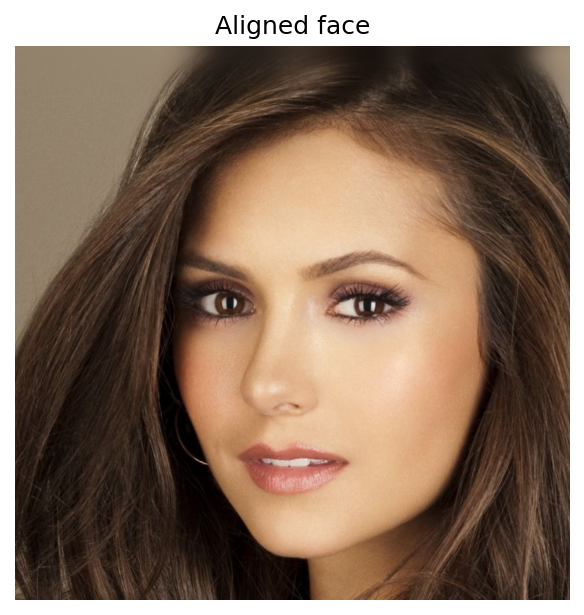

In [3]:
plt.rcParams['figure.dpi'] = 150

#@title My Input Image
#@markdown My input face image is the celebrity, Nina Dobrev. The 'test_input' folder is the path to input images, and you can alter or add images.
filename = 'nina_dobrev.jpg' #@param {type:"string"}
filepath = f'test_input/{filename}'

# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face
aligned_face = align_face(filepath)

# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

display_image(aligned_face, title='Aligned face')

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


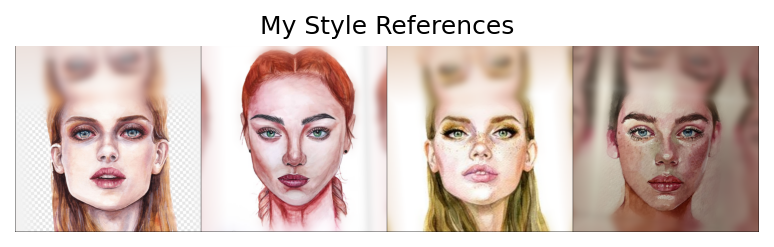

In [4]:
#@title Training
#@markdown I trained my own style through 4 input style images that represent a watercolor painting design using multi-shot image translation. These input style images are located in the 'style_images' folder.
names = ['wcsketch.jpeg', 'wcsketch2.jpeg', 'wcsketch3.jpeg', 'wcsketch4.jpeg'] #@param {type:"raw"}

targets = []
latents = []

for name in names:
    style_path = os.path.join('style_images', name)
    assert os.path.exists(style_path), f"{style_path} does not exist!"

    name = strip_path_extension(name)

    # crop and align the face
    style_aligned_path = os.path.join('style_images_aligned', f'{name}.png')
    if not os.path.exists(style_aligned_path):
        style_aligned = align_face(style_path)
        style_aligned.save(style_aligned_path)
    else:
        style_aligned = Image.open(style_aligned_path).convert('RGB')

    # GAN invert
    style_code_path = os.path.join('inversion_codes', f'{name}.pt')
    if not os.path.exists(style_code_path):
        latent = e4e_projection(style_aligned, style_code_path, device)
    else:
        latent = torch.load(style_code_path)['latent']

    targets.append(transform(style_aligned).to(device))
    latents.append(latent.to(device))

targets = torch.stack(targets, 0)
latents = torch.stack(latents, 0)

target_im = utils.make_grid(targets, normalize=True, range=(-1, 1))
display_image(target_im, title='My Style References')

In [5]:
#@title Finetune StyleGAN
#@markdown The alpha value can be adjusted, and it controls the strength of the style implemented on the image. Increasing alpha will cause the image to resemble the style reference moer strongly, whereas decreasing alpha will keep the image more similar to its original.
alpha =  0.5 #@param {type:"slider", min:0, max:1, step:0.1}
alpha = 1-alpha

#@markdown Here we want to set the preserve_color to True to preserve the colors of the original image by limiting family of allowable transformations. This makes it so that the input image mirrors the original more closely and doesn't lead to heavy stylization. On the contrary, if you want to use the colors of the style references over the original input, set this value to false.
preserve_color = "True" # @param ["True", "False"]
#@markdown The 'num_iter' parameter specifies the number of finetuning steps. For my style reference, I will use 400 iterations, but other styles may require different iterations, like 200 or 500.
num_iter = 400 #@param {type:"number"}
#@markdown Log training on wandb and interval for image logging
use_wandb = False #@param {type:"boolean"}
log_interval = 50 #@param {type:"number"}

if use_wandb:
    wandb.init(project="JoJoGAN")
    config = wandb.config
    config.num_iter = num_iter
    config.preserve_color = preserve_color
    wandb.log(
    {"Style reference": [wandb.Image(transforms.ToPILImage()(target_im))]},
    step=0)


# load discriminator for perceptual loss
discriminator = Discriminator(1024, 2).eval().to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
discriminator.load_state_dict(ckpt["d"], strict=False)


# reset generator
del generator
generator = deepcopy(original_generator)

g_optim = optim.Adam(generator.parameters(), lr=2e-3, betas=(0, 0.99))

# Which layers to swap for generating a family of plausible real images -> fake image
if preserve_color:
    id_swap = [9,11,15,16,17]
else:
    id_swap = list(range(7, generator.n_latent))

for idx in tqdm(range(num_iter)):
    mean_w = generator.get_latent(torch.randn([latents.size(0), latent_dim]).to(device)).unsqueeze(1).repeat(1, generator.n_latent, 1)
    in_latent = latents.clone()
    in_latent[:, id_swap] = alpha*latents[:, id_swap] + (1-alpha)*mean_w[:, id_swap]

    img = generator(in_latent, input_is_latent=True)

    with torch.no_grad():
        real_feat = discriminator(targets)
    fake_feat = discriminator(img)

    loss = sum([F.l1_loss(a, b) for a, b in zip(fake_feat, real_feat)])/len(fake_feat)

    if use_wandb:
        wandb.log({"loss": loss}, step=idx)
        if idx % log_interval == 0:
            generator.eval()
            my_sample = generator(my_w, input_is_latent=True)
            generator.train()
            my_sample = transforms.ToPILImage()(utils.make_grid(my_sample, normalize=True, range=(-1, 1)))
            wandb.log(
            {"Current stylization": [wandb.Image(my_sample)]},
            step=idx)

    g_optim.zero_grad()
    loss.backward()
    g_optim.step()

  0%|          | 0/400 [00:00<?, ?it/s]/content/JoJoGAN/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.0.1+cu118. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
100%|██████████| 400/400 [12:37<00:00,  1.89s/it]


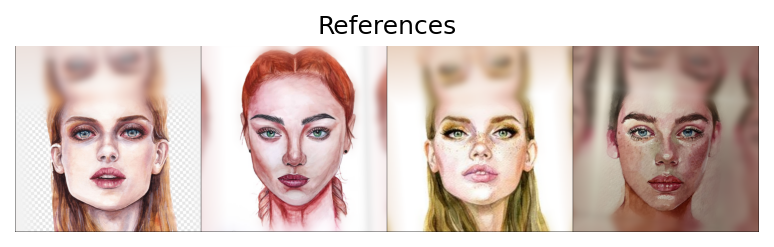

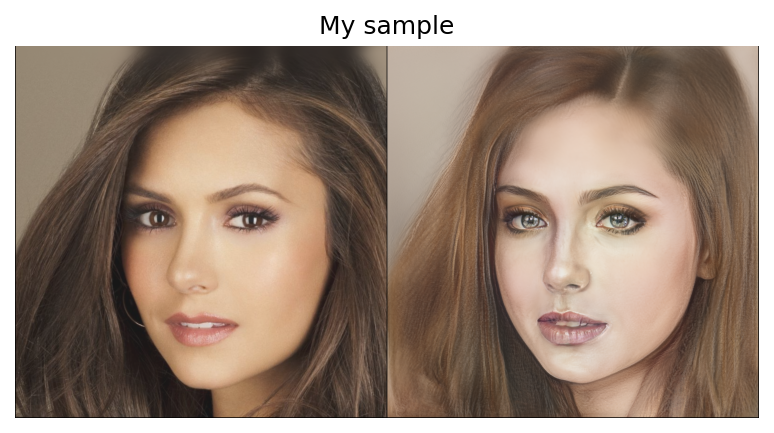

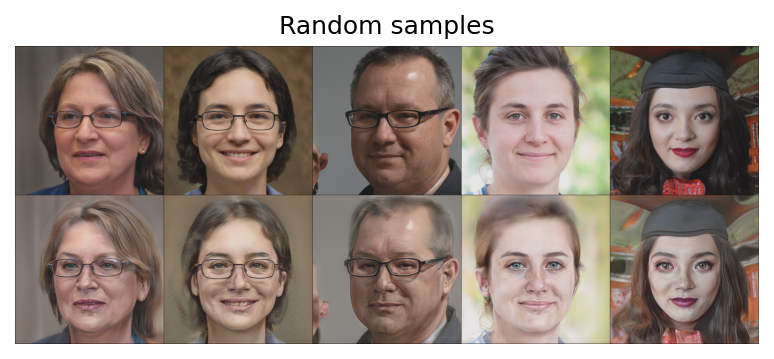

In [10]:
#@title Results
#@markdown After training the StyleGAN on my watercolor style references and finetuning it using the results from the discriminator, I am able to generate the watercolor style art onto my original input image of Nina Dobrev.
n_sample =  5#@param {type:"number"}
seed = 1500 #@param {type:"number"}

torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

# display reference images
style_images = []
for name in names:
    style_path = f'style_images_aligned/{strip_path_extension(name)}.png'
    style_image = transform(Image.open(style_path))
    style_images.append(style_image)

face = transform(aligned_face).to(device).unsqueeze(0)
style_images = torch.stack(style_images, 0).to(device)
display_image(utils.make_grid(style_images, normalize=True, range=(-1, 1)), title='References')

my_output = torch.cat([face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')

output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, range=(-1, 1), nrow=n_sample), title='Random samples')